## Movie Genre Multi-Label Classification with MobileNetV2

[Korean](01_garbage.ko-KR.ipynb) \| [English](01_garbage.en-US.ipynb) \| Copyright (c) 2023 [Jihoon Lucas Kim](https://github.com/kimnamu)

<a href="https://colab.research.google.com/github/kimnamu/cvnets/blob/master/demo/classfication/01_garbage.ko-KR.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"></a>

이 notebook은 Custom Dataset으로 Image Classification 모델을 학습하는 과정을 다루고 있습니다.


## Process
1. Scoping : 문제정의
2. Data : 데이터 수집, 분석
3. Modeling : 적합한 모델 선정
4. Training : 데이터 학습
5. Analysis : 모델 분석 및 평가

## 1. Scoping (문제 정의)

- Garbage Image가 주어졌을 때 해당 Image가 어떤 Garbage인지를 분류합니다.
  - Input : Image File
  - Output : Garbage Class

## 2. Data (데이터 수집 및 분석)
- 데이터 수집은 최초 한번으로 끝나는 것이 아닌 이후 모델링, 학습, 평가 기간동안 계속해서 염두해야 합니다.
- 데이터 분석은 정량적, 정성적으로 살펴보아야 합니다.

### 2.1. Summary

- Dataset Download : https://www.kaggle.com/datasets/jonathanoheix/face-expression-recognition-dataset
- Dataset Tree
    ```
    
        face_expression
        ├─images : original dataset (train + validation)
        │
        ├─train
        │ ├─angry    : 3993 files
        │ ├─disgust  :  436 files
        │ ├─fear     : 4103 files
        │ ├─happy    : 7164 files
        │ ├─neutral  : 4982 files
        │ ├─sad      : 4938 files
        │ └─surprise : 3205 files
        │
        └─validation(val, test)
          ├─angry    : 3993 files
          ├─disgust  :  436 files
          ├─fear     : 4103 files
          ├─happy    : 7164 files
          ├─neutral  : 4982 files
          ├─sad      : 4938 files
          └─surprise : 3205 files
    ```
- Dataset Configuration
    - The number of images : 57642 files
    - The number of classes : 7
        - angry, disgust, fear, happy, neutral, sad, surprise
    - Average number of images per class : 8234 files / class

### 2.2. Data Analysis

실제 데이터에 어떤 이미지가 있는지 살펴봅니다.

(Optional) gdrive에 있는 데이터를 mount 할때 아래와 같이 mount 후 데이터 경로를 지정해줍니다.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
dir_main = "/content/gdrive/MyDrive/dataset/face_expression/"

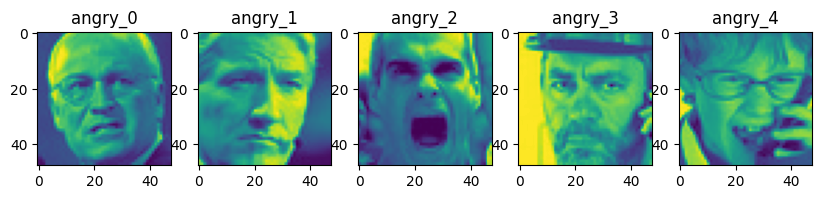

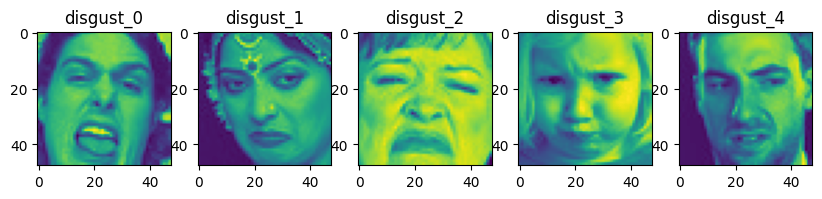

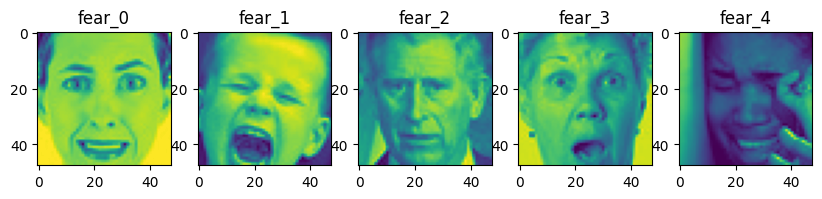

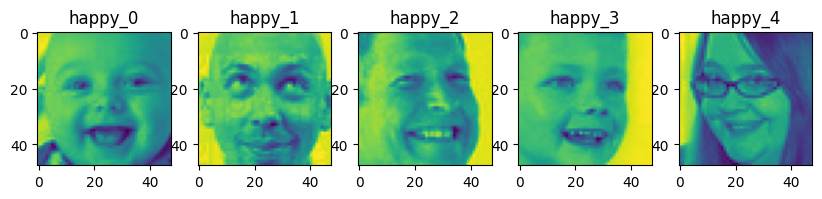

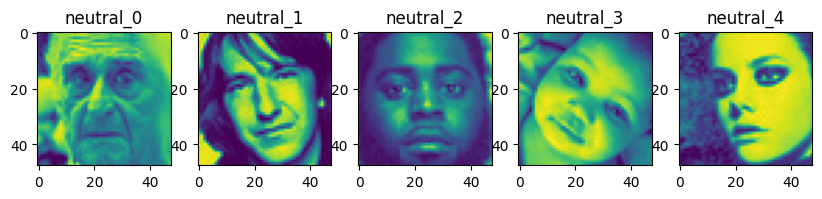

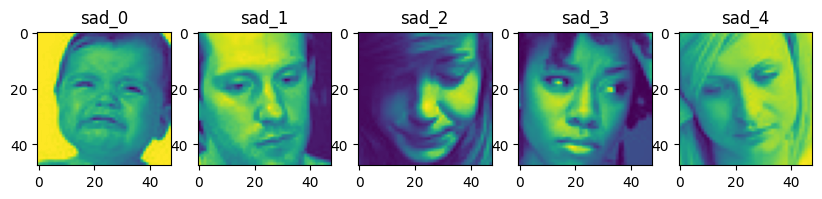

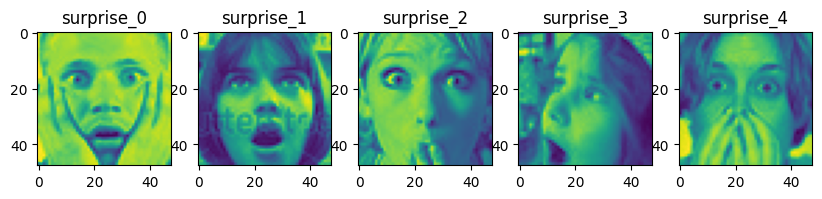

In [1]:
import os
import matplotlib.pyplot as plt
from glob import glob
from PIL import Image

dir_main = "../../../data/face_expression/"
classes = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
source = "train"
image_paths = glob(os.path.join(dir_main, source, "*/*.jpg"))

cls_image_paths = {}
n_show = 5
for cls in classes:
    cls_image_paths[cls] = [image_path for image_path in image_paths if cls == image_path.split("/")[-2]][:n_show]

for cls in classes:
    fig, axes = plt.subplots(nrows=1, ncols=n_show, figsize=(10,2))
    for idx, image_path in enumerate(cls_image_paths[cls]):
        img = Image.open(image_path)
        axes[idx].set_title(f"{cls}_{idx}")
        axes[idx].imshow(img)

### 2.3. Preprocessing dataset for train, validation and test

#### Preprare the dataset

In [2]:
import os
import numpy as np
from glob import glob
from sklearn.model_selection import train_test_split
np.random.seed(724)

dir_main = "../../../data/face_expression/"
classes = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

dir_train = os.path.join(dir_main, 'train')
x_train = glob(f"{dir_train}/*/*.jpg")
y_train = np.array([x.split("/")[-2] for x in x_train])

dir_test = os.path.join(dir_main, 'validation')
x_test = glob(f"{dir_train}/*/*.jpg")
y_test = np.array([x.split("/")[-2] for x in x_test])

dir_val = os.path.join(dir_main, 'validation')
x_val = glob(f"{dir_train}/*/*.jpg")
y_val = np.array([x.split("/")[-2] for x in x_val])

In [3]:
def get_numbers(ys, cls=None):
    cls_cnt = {}
    for y in ys:
        if y not in cls_cnt.keys():
            cls_cnt[y]=0
        cls_cnt[y]+=1
    if cls is None:
        return cls_cnt
    return cls_cnt[cls]

print(f"Class\t\tTrain\tVal\tTest\n")
for cls in classes:
    print(f"{cls:10}\t{get_numbers(y_train, cls)}\t{get_numbers(y_val, cls)}\t{get_numbers(y_test, cls)}")

Class		Train	Val	Test

angry     	3993	3993	3993
disgust   	436	436	436
fear      	4103	4103	4103
happy     	7164	7164	7164
neutral   	4982	4982	4982
sad       	4938	4938	4938
surprise  	3205	3205	3205


### 2.4. Create DataLoader

In [4]:
import torch
from torch.utils.data import Dataset
from glob import glob

class FaceExpressionDataset(Dataset): 
    def __init__(self, dir_dataset, tr):
        self.dir_dataset = os.path.abspath(dir_dataset)
        self.filelist = glob(self.dir_dataset + '/*/*.jpg')
        assert len(self.filelist)!=0, f"{self.dir_dataset + '/*/*.jpg'} is empty"
        self.classes = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
        self.tr = tr

    def get_image(self, filename):
        img = Image.open(filename).convert("RGB")
        img = self.tr(img)
        return img

    def get_label(self, filename):
        label = np.array([0] * len(self.classes))
        cls = filename.split('/')[-2]
        label[self.classes.index(cls)] = 1
        return torch.from_numpy(label).type(torch.FloatTensor)


    def __getitem__(self, idx):
        filename = self.filelist[idx]
        img = self.get_image(filename)
        label = self.get_label(filename)
        return img, label

    def __len__(self): 
        return len(self.filelist)


def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)


In [5]:
from torch.utils.data import DataLoader
import torchvision.transforms as T

# print(model.default_cfg['mean']) # 'mean': (0.485, 0.456, 0.406)
# print(model.default_cfg['std']) # 'std': (0.229, 0.224, 0.225)
normalize = T.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)

train_tr = T.Compose([
    T.Resize((140, 140)),
    T.RandomCrop(128),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    normalize
])

test_tr = T.Compose([
    T.Resize((128, 128)),
    T.ToTensor(),
    normalize
])
train_ds = FaceExpressionDataset(os.path.join(dir_main, "train"), train_tr)
val_ds = FaceExpressionDataset(os.path.join(dir_main, "validation"), test_tr)
test_ds = FaceExpressionDataset(os.path.join(dir_main, "validation"), test_tr)

train_dl = DataLoader(train_ds, shuffle=True, num_workers=0, batch_size=64)
val_dl = DataLoader(val_ds, shuffle=True, num_workers=0, batch_size=64)
test_dl = DataLoader(test_ds, shuffle=True, num_workers=0, batch_size=64)

device = get_default_device()
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
test_dl = DeviceDataLoader(test_dl, device)

### 3. Modeling

#### 3.1. Select Model - MobilenetV2

MobileNetV2: Inverted Residuals and Linear Bottlenecks
 ([Paper](https://arxiv.org/abs/1801.04381)) 이란?

1. Depthwise Separable Convolution

![image.jpg1](https://drive.google.com/uc?id=1wm6KCaD5VdX72jn1elWjZ89ly-eMrad-) |![image.jpg2](https://drive.google.com/uc?id=1NaaR9r1NQ8NLz5ue9emNl6K1ZZMTu3dY)
--- | --- |

- MobileNetV2는 Depthwise Separable Convolution이라는 특별한 컨볼루션 연산을 사용합니다. 이를 통해 더 적은 파라미터로 더 효율적인 연산이 가능해지며, 작은 메모리 용량과 빠른 추론 속도를 보장합니다.

2. Linear Bottlenecks
<center><img src = "https://drive.google.com/uc?id=1NGrK5pHB8LE9xw3WMaI2g_2NQa4R0DAE" height = 300> </center>
- MobileNetV2에서는 Linear Bottlenecks이라는 새로운 레이어를 도입하여, 효율성을 높입니다. 이 레이어는 1x1 Convolution 다음에 ReLU 활성화 함수를 사용하지 않고, 선형 활성화 함수를 사용합니다. 이를 통해 모델 크기를 줄이고, 성능을 향상시킬 수 있습니다.

3. Inverted Residuals
<center><img src = "https://drive.google.com/uc?id=16I5NKGshZTDtLeCbBV8zFY_y45TBMbpY" height = 300> </center>
- MobileNetV2는 Inverted Residuals이라는 새로운 블록 구조를 도입하여, 더 적은 파라미터로 높은 정확도를 달성할 수 있습니다. 이 구조는 Residual 연결을 가지고 있으며, 첫 번째 레이어는 입력 채널 수를 늘리는데 사용됩니다. 이후 Depthwise Separable Convolution을 거친 다음, 두 번째 레이어에서는 출력 채널 수를 줄이는데 사용됩니다.

4. Scalability - Width Multiplier
MobileNetV2에서는 Width Multiplier라는 하이퍼파라미터를 조절하여, 모델 크기와 정확도 사이의 trade-off를 조절할 수 있습니다. Width Multiplier가 작을수록 모델 크기는 작아지지만, 정확도는 낮아집니다. Width Multiplier가 클수록 모델 크기는 커지지만, 정확도는 높아집니다.
이러한 특징들은 MobileNetV2를 경량화된 딥러닝 모델로 만들어주며, 모바일 기기에서의 빠른 추론과 작은 메모리 사용을 가능하게 합니다.

#### 3.2. Package Installation

아래 package를 설치 합니다.
- [timm](https://github.com/rwightman/pytorch-image-models), [opencv](https://github.com/opencv/opencv-python), [sklearn](https://scikit-learn.org/stable/index.html)

```
    # install dependancy
    pip install timm
    pip install opencv-python
    pip install scikit-learn
    # pip install -r requirements.txt
```

#### 3.3. Loading Model

Timm에는 기존에 학습된 여러 pretrained 모델을 제공합니다.

In [6]:
import timm

print(f"The number of pretrained models : {len(timm.list_models('*', pretrained=True))}")
timm.list_models('mobilevit*', pretrained=True)

The number of pretrained models : 770


['mobilevit_s',
 'mobilevit_xs',
 'mobilevit_xxs',
 'mobilevitv2_050',
 'mobilevitv2_075',
 'mobilevitv2_100',
 'mobilevitv2_125',
 'mobilevitv2_150',
 'mobilevitv2_150_384_in22ft1k',
 'mobilevitv2_150_in22ft1k',
 'mobilevitv2_175',
 'mobilevitv2_175_384_in22ft1k',
 'mobilevitv2_175_in22ft1k',
 'mobilevitv2_200',
 'mobilevitv2_200_384_in22ft1k',
 'mobilevitv2_200_in22ft1k']

In [7]:
model = timm.create_model('mobilenetv2_100', pretrained=True)
model.default_cfg

{'url': 'https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/mobilenetv2_100_ra-b33bc2c4.pth',
 'num_classes': 1000,
 'input_size': (3, 224, 224),
 'pool_size': (7, 7),
 'crop_pct': 0.875,
 'interpolation': 'bicubic',
 'mean': (0.485, 0.456, 0.406),
 'std': (0.229, 0.224, 0.225),
 'first_conv': 'conv_stem',
 'classifier': 'classifier',
 'architecture': 'mobilenetv2_100'}

In [8]:
model = timm.create_model('mobilenetv2_100', pretrained=True, num_classes=len(classes), global_pool='avg')
model.eval()
model(torch.randn(1, 3, 224, 224)).shape

[W NNPACK.cpp:53] Could not initialize NNPACK! Reason: Unsupported hardware.


torch.Size([1, 7])

In [9]:
import timm
import torch.nn as nn
import torch.nn.functional as F

class MobileNetV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = timm.create_model('mobilenetv2_100', pretrained=True, num_classes=len(classes), global_pool='avg')
    
    def forward(self, x):
        return torch.sigmoid(self.model(x))

model = MobileNetV2()
# to_device(model, device)

In [10]:
import pickle
import os

class TrainHelper():
    def __init__(self, save_path='./ckpt/history.pickle', history=[]):
        self.history = history
        self.save_path = save_path
        os.makedirs(os.path.dirname(save_path), exist_ok=True)

    def accuracy(self, outputs, labels):
        pred = torch.max(outputs, dim=1)[1]
        gt = torch.max(labels, dim=1)[1]
        return torch.tensor(torch.sum(pred == gt).item() / len(pred))

    @torch.no_grad()
    def validation(self, batch):
        images, labels = batch 
        out = model(images)
        acc = self.accuracy(out, labels)
        loss = F.cross_entropy(out, labels)
        return {'val_loss': loss.detach(), 'val_acc': acc}

    @torch.no_grad()
    def evaluation(self, model, data_loader):
        model.eval()
        outputs = [self.validation(batch) for batch in data_loader]
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss': round(epoch_loss.item(), 5), 'val_acc': round(epoch_acc.item(), 5)}

    def logging(self, epoch, result):
        print("Epoch {}: train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        self.history.append(result)
        with open(self.save_path, 'wb') as f:
            pickle.dump(self.history, f)

train_helper = TrainHelper()

In [11]:
train_helper.evaluation(model, val_dl)

{'val_loss': 1.94766, 'val_acc': 0.16383}

## 4.Training

In [12]:
from tqdm import tqdm

epochs = 20
optimizer = torch.optim.Adam(model.parameters(), 1e-3)
val_acc_best = 0
save_model_path = "./ckpt/"
os.makedirs(save_model_path, exist_ok=True)
for epoch in range(epochs):
    # Training Phase 
    model.train()
    train_losses = []
    for batch in tqdm(train_dl):
        inputs, targets = batch
        outputs = model(inputs)
        loss = F.cross_entropy(outputs, targets)

        train_losses.append(loss)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    # Validation phase
    result = train_helper.evaluation(model, val_dl)
    result['train_loss'] = torch.stack(train_losses).mean().item()

    # Save the best model
    if result['val_acc'] >= val_acc_best:
        val_acc_best = result['val_acc']
        if 'save_model_name' in locals() and os.path.exists(save_model_name):
            os.remove(save_model_name)
        save_model_name = os.path.join(save_model_path, f"best_ep_{epoch}_{val_acc_best}.pt")
        torch.save(model.state_dict(), save_model_name)
        print(f"Saved PyTorch Model State to {save_model_name}")

    train_helper.logging(epoch, result)

# Save the last model
save_model_name = os.path.join(save_model_path, f"last_ep_{epoch}_{val_acc_best}.pt")
torch.save(model.state_dict(), save_model_name)

100%|██████████| 451/451 [13:58<00:00,  1.86s/it]


Saved PyTorch Model State to ./ckpt/best_ep_0_0.49816.pt
Epoch 0: train_loss: 1.6345, val_loss: 1.5872, val_acc: 0.4982


100%|██████████| 451/451 [13:05<00:00,  1.74s/it]


Saved PyTorch Model State to ./ckpt/best_ep_1_0.52417.pt
Epoch 1: train_loss: 1.5658, val_loss: 1.5506, val_acc: 0.5242


100%|██████████| 451/451 [13:03<00:00,  1.74s/it]


Epoch 2: train_loss: 1.5507, val_loss: 1.5543, val_acc: 0.5147


100%|██████████| 451/451 [13:00<00:00,  1.73s/it]


Saved PyTorch Model State to ./ckpt/best_ep_3_0.54862.pt
Epoch 3: train_loss: 1.5425, val_loss: 1.5339, val_acc: 0.5486


100%|██████████| 451/451 [13:12<00:00,  1.76s/it]


Saved PyTorch Model State to ./ckpt/best_ep_4_0.55526.pt
Epoch 4: train_loss: 1.5381, val_loss: 1.5339, val_acc: 0.5553


100%|██████████| 451/451 [13:01<00:00,  1.73s/it]


Saved PyTorch Model State to ./ckpt/best_ep_5_0.56037.pt
Epoch 5: train_loss: 1.5304, val_loss: 1.5270, val_acc: 0.5604


100%|██████████| 451/451 [12:59<00:00,  1.73s/it]


Epoch 6: train_loss: 1.5221, val_loss: 1.5383, val_acc: 0.5452


100%|██████████| 451/451 [12:59<00:00,  1.73s/it]


Epoch 7: train_loss: 1.5270, val_loss: 1.5304, val_acc: 0.5334


100%|██████████| 451/451 [13:23<00:00,  1.78s/it]


Saved PyTorch Model State to ./ckpt/best_ep_8_0.57291.pt
Epoch 8: train_loss: 1.5116, val_loss: 1.5198, val_acc: 0.5729


100%|██████████| 451/451 [13:15<00:00,  1.76s/it]


Epoch 9: train_loss: 1.5064, val_loss: 1.5251, val_acc: 0.5361


100%|██████████| 451/451 [13:14<00:00,  1.76s/it]


Epoch 10: train_loss: 1.5032, val_loss: 1.5092, val_acc: 0.5598


100%|██████████| 451/451 [13:01<00:00,  1.73s/it]


Epoch 11: train_loss: 1.5043, val_loss: 1.5078, val_acc: 0.5664


100%|██████████| 451/451 [13:02<00:00,  1.73s/it]


Saved PyTorch Model State to ./ckpt/best_ep_12_0.5761.pt
Epoch 12: train_loss: 1.5034, val_loss: 1.5024, val_acc: 0.5761


100%|██████████| 451/451 [13:09<00:00,  1.75s/it]


Saved PyTorch Model State to ./ckpt/best_ep_13_0.58798.pt
Epoch 13: train_loss: 1.4888, val_loss: 1.4980, val_acc: 0.5880


100%|██████████| 451/451 [13:03<00:00,  1.74s/it]


Epoch 14: train_loss: 1.4934, val_loss: 1.5082, val_acc: 0.5577


100%|██████████| 451/451 [13:02<00:00,  1.74s/it]


Epoch 15: train_loss: 1.4921, val_loss: 1.5082, val_acc: 0.5625


100%|██████████| 451/451 [13:00<00:00,  1.73s/it]


Saved PyTorch Model State to ./ckpt/best_ep_16_0.59177.pt
Epoch 16: train_loss: 1.4836, val_loss: 1.4997, val_acc: 0.5918


100%|██████████| 451/451 [13:06<00:00,  1.74s/it]


Saved PyTorch Model State to ./ckpt/best_ep_17_0.59662.pt
Epoch 17: train_loss: 1.4847, val_loss: 1.4886, val_acc: 0.5966


100%|██████████| 451/451 [13:02<00:00,  1.74s/it]


Saved PyTorch Model State to ./ckpt/best_ep_18_0.61057.pt
Epoch 18: train_loss: 1.4758, val_loss: 1.4814, val_acc: 0.6106


100%|██████████| 451/451 [13:00<00:00,  1.73s/it]


Epoch 19: train_loss: 1.4739, val_loss: 1.4843, val_acc: 0.5949


##### Train & Validation Losses

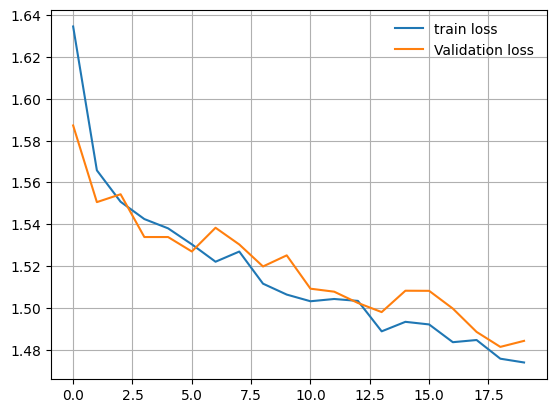

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt

train_loss = [history['train_loss'] for history in train_helper.history]
val_loss = [history['val_loss'] for history in train_helper.history]

plt.plot(train_loss, label='train loss')
plt.plot(val_loss, label='Validation loss')
plt.grid()
plt.legend(frameon=False)

##### Accuracy

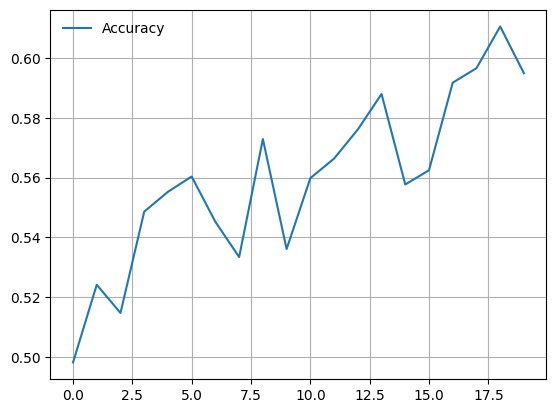

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt

val_acc = [history['val_acc'] for history in train_helper.history]
plt.plot(val_acc, label='Accuracy')
plt.grid()
plt.legend(frameon=False)

## 5. Analysis

##### Confusion Matrix

100%|██████████| 111/111 [00:43<00:00,  2.57it/s]
/Users/jihoon.kim/opt/anaconda3/envs/cvnets/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jihoon.kim/opt/anaconda3/envs/cvnets/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jihoon.kim/opt/anaconda3/envs/cvnets/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter

Classes : ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
Performance 
              precision    recall  f1-score   support

           0      0.467     0.626     0.535       960
           1      0.000     0.000     0.000       111
           2      0.432     0.395     0.413      1018
           3      0.822     0.861     0.841      1825
           4      0.501     0.718     0.590      1216
           5      0.522     0.239     0.328      1139
           6      0.717     0.606     0.657       797

    accuracy                          0.595      7066
   macro avg      0.494     0.492     0.481      7066
weighted avg      0.589     0.595     0.578      7066



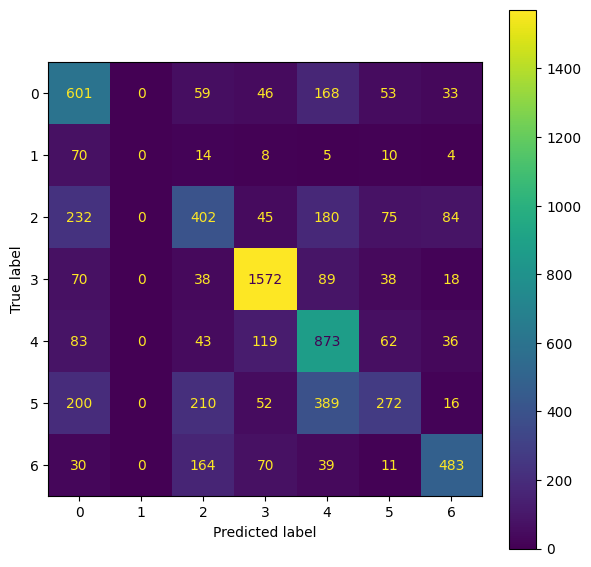

In [15]:
from sklearn import metrics
import matplotlib.pyplot as plt

model.eval()

y_pred = []
y_true = []
for batch in tqdm(test_dl):
    inputs, targets = batch
    outputs = model(inputs)
    y_pred.extend(torch.max(outputs, dim=1)[1].numpy())
    y_true.extend(torch.max(targets, dim=1)[1].numpy())

performance = metrics.classification_report(y_true, y_pred, digits=3)
confusion_matrix = metrics.confusion_matrix(y_true, y_pred)

classes = test_ds.classes
disp = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = list(range(len(classes))))
print(f"Classes : {classes}")
print(f"Performance \n{performance}")

disp.plot()
fig = disp.ax_.get_figure() 
fig.set_figwidth(len(classes))
fig.set_figheight(len(classes)) 
plt.savefig("confusion_matrix.jpg")
plt.show()

#### Load Trained Model

In [20]:
import torch

model=MobileNetV2()
model.load_state_dict(torch.load("./ckpt/best_ep_18_0.61057.pt", map_location='cpu'))

<All keys matched successfully>

In [16]:
# Recovery of normalized image dataset for visualization
normalize_inverted = T.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)

#### False Positive Cases

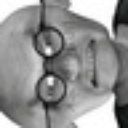

Prediction   : neutral (1.0000)
Ground Truth : angry


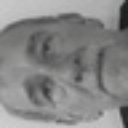

Prediction   : angry (1.0000)
Ground Truth : fear


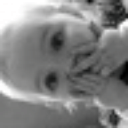

Prediction   : happy (1.0000)
Ground Truth : fear


In [17]:
from IPython.display import display
from PIL import Image
FP = 3
for data in test_dl:
    if FP==0:
        break
    img_batch, label_batch = data
    results = model(img_batch)
    confs, preds = torch.max(results, dim=1)
    _, gts = torch.max(label_batch, dim=1)
    preds = preds.numpy()
    confs = confs.detach().numpy()
    gts = gts.numpy()
    
    for img, p, conf, g in zip(img_batch, preds, confs, gts):
        if FP <= 0:
            break
        x = normalize_inverted(img).numpy()
        x = (x * 255).astype(np.uint8).T
        x = Image.fromarray(x)
        if p!=g:
            display(x)
            print(f"Prediction   : {test_ds.classes[p]} ({conf:0.4f})")
            print(f"Ground Truth : {test_ds.classes[g]}")
            FP -= 1


#### True Positive Cases

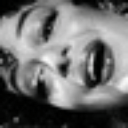

Prediction   : happy (1.0000)
Ground Truth : happy


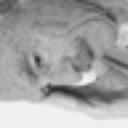

Prediction   : fear (1.0000)
Ground Truth : fear


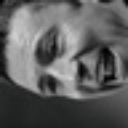

Prediction   : happy (1.0000)
Ground Truth : happy


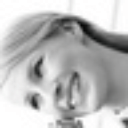

Prediction   : happy (1.0000)
Ground Truth : happy


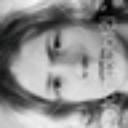

Prediction   : neutral (1.0000)
Ground Truth : neutral


In [22]:
TP = 5
for data in test_dl:
    if TP <= 0:
        break
    img_batch, label_batch = data
    results = model(img_batch)
    confs, preds = torch.max(results, dim=1)
    _, gts = torch.max(label_batch, dim=1)
    preds = preds.numpy()
    confs = confs.detach().numpy()
    gts = gts.numpy()
    
    for img, p, conf, g in zip(img_batch, preds, confs, gts):
        if TP <= 0:
            break
        x = normalize_inverted(img).numpy()
        x = (x * 255).astype(np.uint8).T
        x = Image.fromarray(x)
        if p==g:
            display(x)
            print(f"Prediction   : {test_ds.classes[p]} ({conf:0.4f})")
            print(f"Ground Truth : {test_ds.classes[g]}")
            TP -= 1